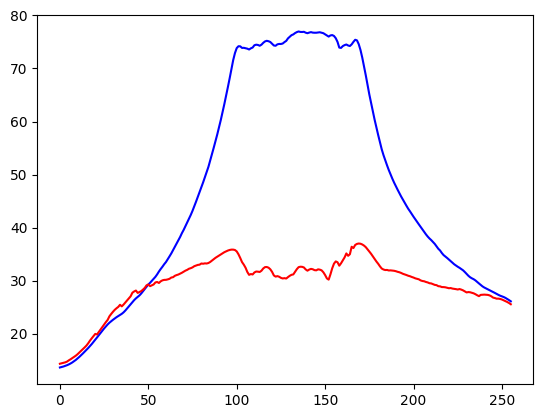

In [6]:
import numpy as np 
from matplotlib import pyplot as plt

orig_psnr = np.loadtxt('/lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/psnr.txt')
post_psnr = np.loadtxt('/lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/psnr_predict.txt')
plt.plot(orig_psnr, label='original', color='blue')
plt.plot(post_psnr, label='post', color='red') 

In [ ]:
! cd ../test 
! python predict_single.py  --input /lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/quantized_data/slice_0063.f32  --target /lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/orig_data/slice_0063.f32  --shape 200 200  --modelpath /lcrc/project/SDR/pjiao/data/cnn_train/patches_64_32/models/cuda_epoch_99.pth  --output_dir ./ 

In [21]:
import os 
import sys 
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('./'), '../src'))) 
from stats import get_psnr, qcatssim

In [19]:
pred = np.fromfile("../test/pred.f32", dtype=np.float32).reshape(200, 200)
orig = np.fromfile("/lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/orig_data/slice_0063.f32", dtype=np.float32).reshape(200, 200)
quantized = np.fromfile("/lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/quantized_data/slice_0063.f32", dtype=np.float32).reshape(200, 200)
compensated = np.fromfile("/lcrc/project/ECP-EZ/jp/git/posterization_mitigation/build/test/test.c", dtype=np.float32).reshape(200, 200) 
quantized_psnr = get_psnr(orig, quantized) 
quantized_ssim = qcatssim( orig, quantized)
pred_psnr = get_psnr(orig, pred)
pred_ssim = qcatssim(orig,pred)
c_ssim = qcatssim(orig, compensated) 
c_psnr = get_psnr(orig, compensated) 

print("quantized psnr: ", quantized_psnr)
print("quantized ssim: ", quantized_ssim)
print("pred psnr: ", pred_psnr)
print("pred ssim: ", pred_ssim)
print("compensated psnr: ", c_psnr)
print("compensated ssim: ", c_ssim)

abs err=0.00099994196
abs err=0.012759348
abs err=0.0017025936
quantized psnr:  35.123146
quantized ssim:  0.6869311734123492
pred psnr:  30.57553
pred ssim:  0.8973567911169338
compensated psnr:  43.75023
compensated ssim:  0.9455113177139088


Text(0.5, 1.0, 'Predicted, PSNR: 30.58, SSIM: 0.90')

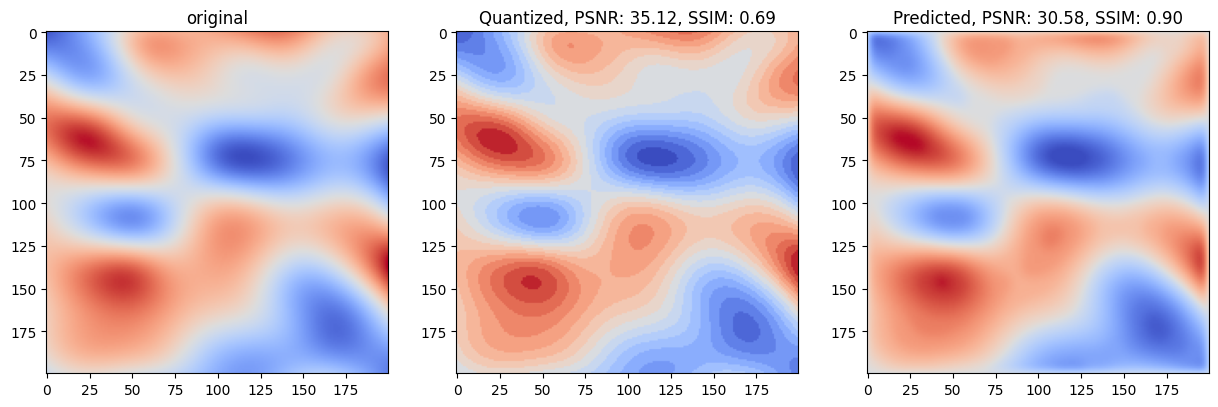

In [15]:
figs,ax = plt.subplots(1, 3, figsize=(15, 5))
v_max = np.max(orig)
v_min = np.min(orig)
ax[0].imshow(orig, cmap='coolwarm')
ax[0].set_title('original')
ax[1].imshow(quantized, cmap='coolwarm', vmin=v_min, vmax=v_max)
ax[1].set_title(f'Quantized, PSNR: {quantized_psnr:.2f}, SSIM: {quantized_ssim:.2f}')
ax[2].imshow(pred, cmap='coolwarm', vmin=v_min, vmax=v_max)
ax[2].set_title(f'Predicted, PSNR: {pred_psnr:.2f}, SSIM: {pred_ssim:.2f}')

Text(0.5, 1.0, 'learned  residual')

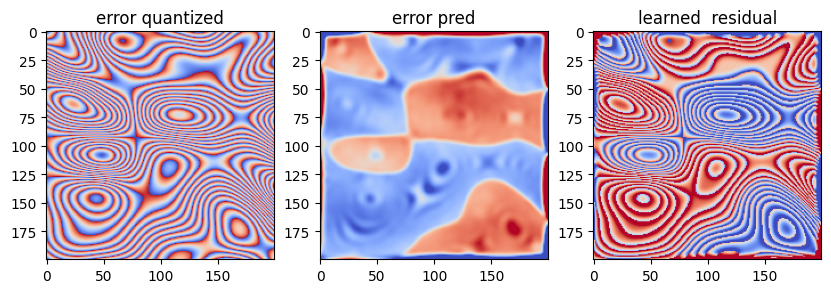

In [18]:
error_quantized = orig - quantized
error_pred = orig - pred 
error_residual = pred- quantized
figs,ax = plt.subplots(1, 3, figsize=(10, 5))
e_max = np.max(abs(error_quantized))
e_min = -e_max 
ax[0].imshow(error_quantized, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[0].set_title('error quantized')
ax[1].imshow(error_pred, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[1].set_title('error pred')
ax[2].imshow(error_residual, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[2].set_title('learned  residual')

In [21]:
## residual model 
import numpy as np 
from matplotlib import pyplot as plt
import sys 
import os 
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('./'), '../src'))) 
from model import ARCNN 
from stats import get_psnr, qcatssim
import torch 

modelpath = '/lcrc/project/ECP-EZ/jp/git/arcnn/test/best_residual_model.pth'
orig = np.fromfile("/lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/orig_data/slice_0063.f32", dtype=np.float32).reshape(200, 200)
quantized = np.fromfile("/lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/quantized_data/slice_0063.f32", dtype=np.float32).reshape(200, 200)
# orig = orig[0:100, 0:100].copy()
# quantized = quantized[0:100, 0:100].copy()
residuals = orig - quantized
max_residual = residuals.max() 
min_residual = residuals.min()
print(max_residual, min_residual) 
residual_bound = np.max(np.abs(residuals))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load model
model = ARCNN().to(device)
model.load_state_dict(torch.load(modelpath, map_location=device))
model.eval()
# normalize the input
quantized_copy = quantized.copy() 
quantized = (quantized - quantized.min()) / (quantized.max() - quantized.min())*2-1
# quantized = quantized/residual_bound
input_max = quantized.max() 
input_min = quantized.min() 
input_tensor = torch.from_numpy(quantized).unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    pred_residual = model(input_tensor)
pred_residual = pred_residual.squeeze().cpu().numpy()
print(pred_residual.max(), pred_residual.min())  
# pred_residual = (pred_residual + 1) / 2 * (max_residual - min_residual) + min_residual 
pred_residual = pred_residual * residual_bound
print(pred_residual.max(), pred_residual.min())  
pred = quantized_copy + pred_residual
quantized = quantized_copy
orig_psnr = get_psnr(orig, quantized_copy)
orig_ssim = qcatssim(orig, quantized_copy) 
pred_psnr = get_psnr(orig, pred)
pred_ssim = qcatssim(orig, pred)
print("orig psnr: ", orig_psnr)
print("orig ssim: ", orig_ssim)
print("pred psnr: ", pred_psnr)
print("pred ssim: ", pred_ssim)



0.0009997524 -0.000999942
0.7495587 -0.7460218
0.0007495152 -0.0007459785
abs err=0.00099994196
abs err=0.0013422541
orig psnr:  35.123146
orig ssim:  0.6869311734123492
pred psnr:  37.201637
pred ssim:  0.8121996441986276


Text(0.5, 1.0, 'compensated, PSNR: 43.75, SSIM: 0.95')

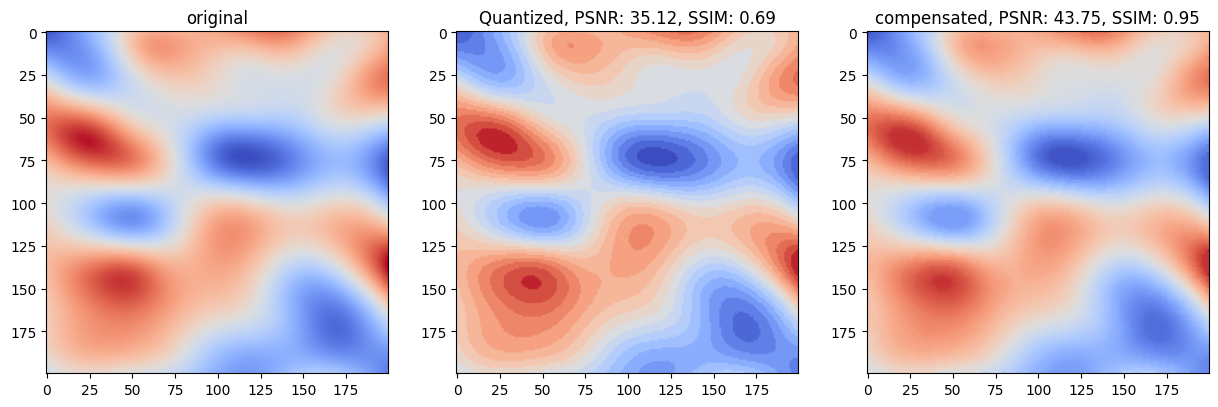

In [22]:
# plot the results 
figs,ax = plt.subplots(1, 3, figsize=(15, 5))
v_max = np.max(orig)
v_min = np.min(orig)
ax[0].imshow(orig, cmap='coolwarm')
ax[0].set_title('original')
ax[1].imshow(quantized, cmap='coolwarm', vmin=v_min, vmax=v_max)
ax[1].set_title(f'Quantized, PSNR: {orig_psnr:.2f}, SSIM: {orig_ssim:.2f}')
# ax[2].imshow(compensated, cmap='coolwarm', vmin=v_min, vmax=v_max)
# ax[2].set_title(f'Predicted, PSNR: {pred_psnr:.2f}, SSIM: {pred_ssim:.2f}')
ax[2].imshow(compensated, cmap='coolwarm', vmin=v_min, vmax=v_max)
ax[2].set_title(f'compensated, PSNR: {c_psnr:.2f}, SSIM: {c_ssim:.2f}')


Text(0.5, 1.0, 'Learned residual')

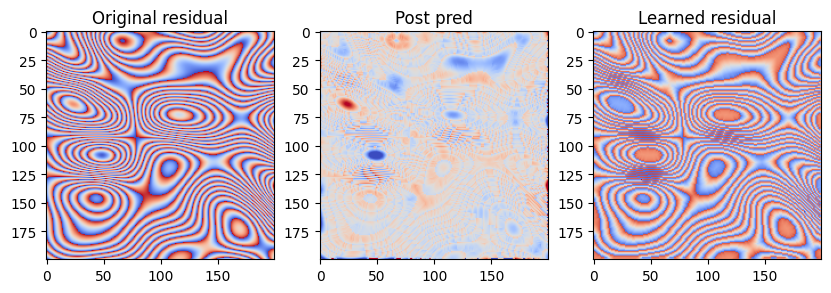

In [23]:
# plot error distribution 
error_quantized = orig - quantized
error_pred = orig - compensated
error_residual = compensated-quantized
figs,ax = plt.subplots(1, 3, figsize=(10, 5))
e_max = np.max(abs(error_quantized))
e_min = -e_max
ax[0].imshow(error_quantized, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[0].set_title('Original residual')
ax[1].imshow(error_pred, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[1].set_title('Post pred')
ax[2].imshow(error_residual, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[2].set_title('Learned residual')


Text(0.5, 1.0, 'Learned residual')

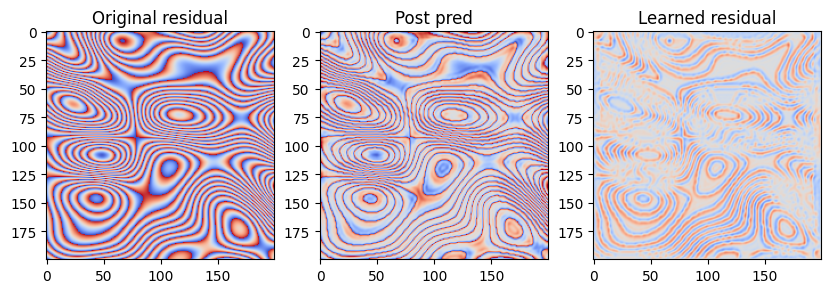

In [ ]:
# plot error distribution 
error_quantized = orig - quantized
error_pred = orig - pred
error_residual = pred-quantized
figs,ax = plt.subplots(1, 3, figsize=(10, 5))
e_max = np.max(abs(error_quantized))
e_min = -e_max
ax[0].imshow(error_quantized, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[0].set_title('Original residual')
ax[1].imshow(error_pred, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[1].set_title('Post pred')
ax[2].imshow(error_residual, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[2].set_title('Learned residual')


In [ ]:
## residual model 
import numpy as np 
from matplotlib import pyplot as plt
import sys 
import os 
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('./'), '../src'))) 
from model import ARCNN 
from stats import get_psnr, qcatssim
import torch 

modelpath = '/lcrc/project/ECP-EZ/jp/git/arcnn/test/best_residual_model.pth'
orig = np.fromfile("/lcrc/project/SDR/pjiao/data/cnn_train/velocityx.f32/orig_data/slice_0063.f32", dtype=np.float32).reshape(200, 200)
quantized = np.fromfile("/lcrc/project/SDR/pjiao/data/cnn_train/velocityx.f32/quantized_data/slice_0063.f32", dtype=np.float32).reshape(200, 200)
# orig = orig[0:100, 0:100].copy()
# quantized = quantized[0:100, 0:100].copy()
residuals = orig - quantized
max_residual = residuals.max() 
min_residual = residuals.min()
print(max_residual, min_residual) 
residual_bound = np.max(np.abs(residuals))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load model
# model = ARCNN().to(device)
model = DnCNN().to(device) 
model.load_state_dict(torch.load(modelpath, map_location=device))
model.eval()
# normalize the input
quantized_copy = quantized.copy() 
quantized = (quantized - quantized.min()) / (quantized.max() - quantized.min())*2-1
# quantized = quantized/residual_bound
input_max = quantized.max() 
input_min = quantized.min() 
input_tensor = torch.from_numpy(quantized).unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    pred_residual = model(input_tensor)
pred_residual = pred_residual.squeeze().cpu().numpy()
print(pred_residual.max(), pred_residual.min())  
# pred_residual = (pred_residual + 1) / 2 * (max_residual - min_residual) + min_residual 
pred_residual = pred_residual * residual_bound
print(pred_residual.max(), pred_residual.min())  
pred = quantized_copy + pred_residual
quantized = quantized_copy
orig_psnr = get_psnr(orig, quantized_copy)
orig_ssim = qcatssim(orig, quantized_copy) 
pred_psnr = get_psnr(orig, pred)
pred_ssim = qcatssim(orig, pred)
print("orig psnr: ", orig_psnr)
print("orig ssim: ", orig_ssim)
print("pred psnr: ", pred_psnr)
print("pred ssim: ", pred_ssim)



0.0010000002 -0.0009999413
0.7084175 -0.6960364
0.0007084176 -0.0006960365
abs err=0.0010000002
abs err=0.0013601752
orig psnr:  36.38463
orig ssim:  0.7001259645985144
pred psnr:  38.111412
pred ssim:  0.8064414289559303


Text(0.5, 1.0, 'Predicted, PSNR: 38.11, SSIM: 0.81')

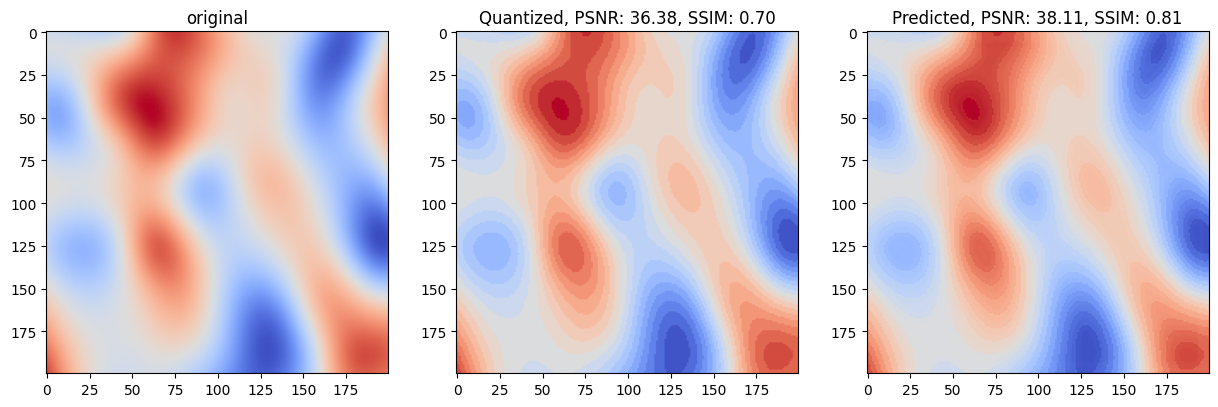

In [9]:
# plot the results 
figs,ax = plt.subplots(1, 3, figsize=(15, 5))
v_max = np.max(orig)
v_min = np.min(orig)
ax[0].imshow(orig, cmap='coolwarm')
ax[0].set_title('original')
ax[1].imshow(quantized, cmap='coolwarm', vmin=v_min, vmax=v_max)
ax[1].set_title(f'Quantized, PSNR: {orig_psnr:.2f}, SSIM: {orig_ssim:.2f}')
ax[2].imshow(pred, cmap='coolwarm', vmin=v_min, vmax=v_max)
ax[2].set_title(f'Predicted, PSNR: {pred_psnr:.2f}, SSIM: {pred_ssim:.2f}')

Text(0.5, 1.0, 'Learned residual')

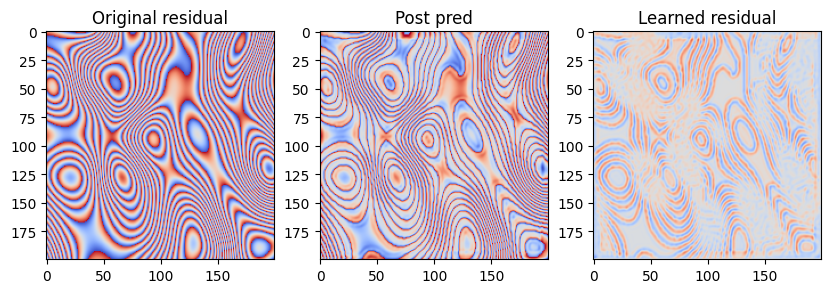

In [11]:
# plot error distribution 
error_quantized = orig - quantized
error_pred = orig - pred
error_residual = pred-quantized
figs,ax = plt.subplots(1, 3, figsize=(10, 5))
e_max = np.max(abs(error_quantized))
e_min = -e_max
ax[0].imshow(error_quantized, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[0].set_title('Original residual')
ax[1].imshow(error_pred, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[1].set_title('Post pred')
ax[2].imshow(pred_residual, cmap='coolwarm', vmin=e_min, vmax=e_max)
ax[2].set_title('Learned residual')

In [6]:
## residual model 
import numpy as np 
from matplotlib import pyplot as plt
import sys 
import os 
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('./'), '../src'))) 
from model import ARCNN, SRCNN, DnCNN 
from stats import get_psnr, qcatssim
import torch 

def report(model_str, modelpath):
    # modelpath = '/lcrc/project/ECP-EZ/jp/git/arcnn/test/best_residual_model.pth'
    orig = np.fromfile("/lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/orig_data/slice_0063.f32", dtype=np.float32).reshape(200, 200)
    quantized = np.fromfile("/lcrc/project/SDR/pjiao/data/cnn_train/velocityy.f32/quantized_data/slice_0063.f32", dtype=np.float32).reshape(200, 200)
    # orig = orig[0:100, 0:100].copy()
    # quantized = quantized[0:100, 0:100].copy()
    residuals = orig - quantized
    max_residual = residuals.max()
    min_residual = residuals.min()
    print(max_residual, min_residual) 
    residual_bound = np.max(np.abs(residuals))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load model
    if(model_str == 'srcnn'):
        model = SRCNN().to(device)
    elif(model_str == 'dncnn'):
        model = DnCNN().to(device)
    elif(model_str == 'arcnn'):
        model = ARCNN().to(device)
    else:
        raise ValueError("Invalid model name. Choose from 'arcnn', 'srcnn', or 'dncnn'.") 
    
    # model = ARCNN().to(device)
    model.load_state_dict(torch.load(modelpath, map_location=device))
    model.eval()
    # normalize the input
    quantized_copy = quantized.copy() 
    quantized = (quantized - quantized.min()) / (quantized.max() - quantized.min())*2-1
    # quantized = quantized/residual_bound
    input_max = quantized.max() 
    input_min = quantized.min() 
    input_tensor = torch.from_numpy(quantized).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_residual = model(input_tensor)
    pred_residual = pred_residual.squeeze().cpu().numpy()
    print(pred_residual.max(), pred_residual.min())  
    # pred_residual = (pred_residual + 1) / 2 * (max_residual - min_residual) + min_residual 
    pred_residual = pred_residual * residual_bound
    print(pred_residual.max(), pred_residual.min())  
    pred = quantized_copy + pred_residual
    quantized = quantized_copy
    orig_psnr = get_psnr(orig, quantized_copy)
    orig_ssim = qcatssim(orig, quantized_copy) 
    pred_psnr = get_psnr(orig, pred)
    pred_ssim = qcatssim(orig, pred)
    print("orig psnr: ", orig_psnr)
    print("orig ssim: ", orig_ssim)
    print("pred psnr: ", pred_psnr)
    print("pred ssim: ", pred_ssim)
    
    # plot the results 
    figs1,ax1 = plt.subplots(1, 3, figsize=(15, 5))
    v_max = np.max(orig)
    v_min = np.min(orig)
    ax1[0].imshow(orig, cmap='coolwarm')
    ax1[0].set_title('original')
    ax1[1].imshow(quantized, cmap='coolwarm', vmin=v_min, vmax=v_max)
    ax1[1].set_title(f'Quantized, PSNR: {orig_psnr:.2f}, SSIM: {orig_ssim:.2f}')
    ax1[2].imshow(pred, cmap='coolwarm', vmin=v_min, vmax=v_max)
    ax1[2].set_title(f'Predicted, PSNR: {pred_psnr:.2f}, SSIM: {pred_ssim:.2f}')
    
    
    # plot error distribution 1
    error_quantized = orig - quantized
    error_pred = orig - pred
    error_residual = pred-quantized
    figs2,ax = plt.subplots(1, 3, figsize=(10, 5))
    e_max = np.max(abs(error_quantized))
    e_min = -e_max
    ax[0].imshow(error_quantized, cmap='coolwarm', vmin=e_min, vmax=e_max)
    ax[0].set_title('Original residual')
    ax[1].imshow(error_pred, cmap='coolwarm', vmin=e_min, vmax=e_max)
    ax[1].set_title('Post pred')
    ax[2].imshow(pred_residual, cmap='coolwarm', vmin=e_min, vmax=e_max)
    ax[2].set_title('Learned residual')



0.0009997524 -0.000999942
1.0623827 -1.0669637
0.001062321 -0.0010669017
abs err=0.00099994196
abs err=0.00084814196
orig psnr:  35.123146
orig ssim:  0.6869311734123492
pred psnr:  52.103737
pred ssim:  0.9745060633530711


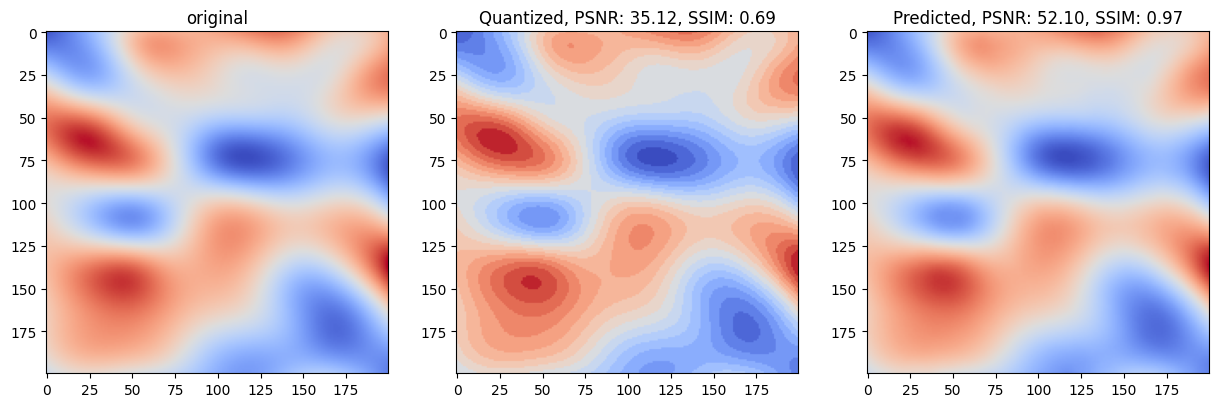

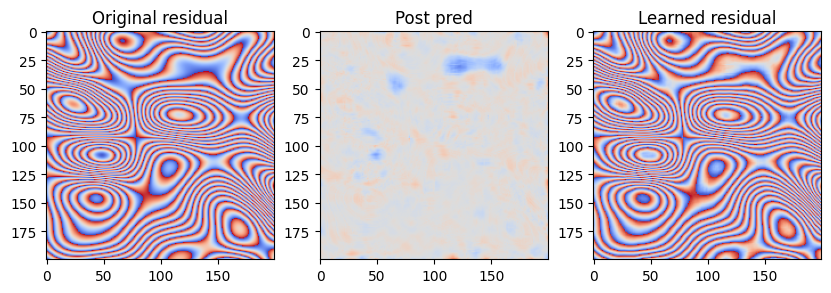

In [13]:
# report('arcnn', '/lcrc/project/ECP-EZ/jp/git/arcnn/test/best_residual_model.pth') 
# report('srcnn', '/lcrc/project/ECP-EZ/jp/git/arcnn/test/best_residual_model_srcnn.pth') 
report('dncnn', '/lcrc/project/ECP-EZ/jp/git/arcnn/test/best_residual_model_dncnn.pth') 